# STAT3009 Project 2
| Name               | Student ID |
|--------------------|------------|
| LAW Yiu Leung Eric | 1155149315 |
| LAM Wai Chiu       | 1155152095 |
| TSOI Tung Sing     | 1155127274 |

# Import packages and load the developed methods
## Packages

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from numpy.linalg import norm

from scipy.sparse import lil_matrix

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Load the existing methods

In [2]:
from developed_methods import *

In [3]:
import scipy as sp
from scipy.stats import chi2

def mahalanobis_method(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           #Covariance
    inv_covmat = sp.linalg.inv(cov)                     #Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

def save_csv(df, folder_path, method):
    nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")
    fileName = "{folder_path}/{method}_{nowTime}.csv".format(folder_path = folder_path, method = method, nowTime = nowTime)
    df.to_csv(fileName, index = False)

# Load Data and Pre-prcossing

In [4]:
# Load dataset
train_rating = pd.read_csv("../data/train_rating.csv")
test_pair = pd.read_csv("../data/test_pair.csv")

item_feat = pd.read_csv("../data/item_feats.csv")
user_feat = pd.read_csv("../data/user_feats.csv")

sub = pd.read_csv('../predict/sample_submission.csv')

## Feature engineering
- check the `UserId` and `ItemId`: mapping `ItemId` to a continuous sequence based on `sklean.preprocessing`
- create `train_pair`,`train_rating`, `test_pair`
- handling missing value by mean
- handling -inf by min

In [5]:
# UserID
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(np.append(train_rating['UserId'], test_pair["UserId"]), user_feat["UserId"]))

user_feat['UserId'] = le_user.transform(user_feat["UserId"])
test_pair["UserId"] = le_user.transform(test_pair["UserId"])
train_rating['UserId'] = le_user.transform(train_rating["UserId"])

# ItemID
le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(np.append(train_rating['ItemId'], test_pair["ItemId"]), item_feat["ItemId"]))

item_feat['ItemId'] = le_item.transform(item_feat["ItemId"])
test_pair["ItemId"] = le_item.transform(test_pair["ItemId"])
train_rating['ItemId'] = le_item.transform(train_rating["ItemId"])

#Inf value
user_feat.loc[np.isinf(user_feat['V1']),'V1']=-3
item_feat.loc[np.isinf(item_feat['V2']),'V2']=2

# Missing data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(user_feat['V1'].values.reshape(-1, 1))
user_feat['V1'] = imp_mean.transform(user_feat['V1'].values.reshape(-1, 1))

## Create train pairs and test pairs

In [6]:
# tran_pair, train_rating
train_pairs = train_rating[['UserId', 'ItemId']].values
train_ratings = train_rating['rating'].values
train_pair=train_rating.drop(columns='rating')

# test_pair
test_pairs = test_pair[['UserId', 'ItemId']].values

# number of users and items
# n_user, n_item = len(le_item.classes_), len(le_item.classes_)

## Check if some users rated same movie more than once

In [9]:
tmp = train_rating.sort_values(["UserId", "ItemId"])

# number of unique item ratings of each user
tmp_unique = tmp.groupby(["UserId"])["ItemId"].agg("unique").map(lambda x: len(x))
# number of ratings of each user
tmp_len = tmp.groupby(["UserId"])["ItemId"].agg("count")

n_user_train = len(set(train_rating["UserId"]))
print("n_user in dtrain =", n_user_train)
n_user_matched = sum(tmp_unique == tmp_len)
print("Number of matched ratins =", n_user_matched)

if(n_user_train == n_user_matched):
    print("There is no movies rated more than once by single user.")
else:
    print("There is {} users rated same movie again.".format(n_user_train - n_user_matched))

n_user in dtrain = 5766
Number of matched ratins = 5766
There is no movies rated more than once by single user.


In [7]:
temp_train_user=np.zeros((len(train_pairs[:,0]), 4))
temp_train_item=np.zeros((len(train_pairs[:,0]), 3))

temp_test_user=np.zeros((len(test_pairs[:,0]), 4))
temp_test_item=np.zeros((len(test_pairs[:,0]), 3))

for i in range(0,len(train_pairs[:,0])):
    temp_train_user[i,:]=user_feat.loc[np.where(train_pairs[i,0]==user_feat.values[:,0])[0][0]].values[1:5]
    temp_train_item[i,:]=item_feat.loc[np.where(train_pairs[i,1]==item_feat.values[:,0])[0][0]].values[1:4]

for i in range(0,len(test_pairs[:,0])):
    temp_test_user[i,:]=user_feat.loc[np.where(test_pairs[i,0]==user_feat.values[:,0])[0][0]].values[1:5]
    temp_test_item[i,:]=item_feat.loc[np.where(test_pairs[i,1]==item_feat.values[:,0])[0][0]].values[1:4]

In [8]:
temp_train_user=pd.DataFrame(temp_train_user,columns=['V1','V2','V3','V4'])
temp_train_item=pd.DataFrame(temp_train_item,columns=['V1','V2','V3'])
temp_test_user=pd.DataFrame(temp_test_user,columns=['V1','V2','V3','V4'])
temp_test_item=pd.DataFrame(temp_test_item,columns=['V1','V2','V3'])

user_pd_train = temp_train_user
item_pd_train = temp_train_item
user_pd_test = temp_test_user
item_pd_test = temp_test_item

## Detect outliers by using mahalanobis distance

In [9]:
df=pd.DataFrame(np.column_stack((user_pd_train,item_pd_train,train_ratings)))
outlier, md=mahalanobis_method(df)

In [10]:
# drop outliers
train_ratings=np.delete(train_ratings,[outlier], axis=0)
train_pairs=np.delete(train_pairs,[outlier], axis=0)
temp_train_user.drop(temp_train_user.index[outlier], inplace=True)
temp_train_item.drop(temp_train_item.index[outlier], inplace=True)
train_rating.drop(train_rating.index[outlier], inplace=True)

In [11]:
n_user, n_item = max(train_pairs[:,0].max(), test_pairs[:,0].max())+1, max(train_pairs[:,1].max(), test_pairs[:,1].max())+1

## Pre-processing the dataset

All continuous features should be standardized as mean 0, std 1

In [12]:
## training data
## pre-processing for users
user_cont = ['V1','V2','V3','V4']
user_pd_train[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd_train[user_cont])

## pre-processing for items
item_cont = ['V1','V2','V3']
item_pd_train[item_cont] = preprocessing.StandardScaler().fit_transform(item_pd_train[item_cont])


print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd_train.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd_train.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
             V1        V2        V3        V4
33868 -0.419020  0.494033  0.332414 -1.694194
8710   0.030562 -0.197844 -0.814013 -1.292310
13013 -1.100018  1.736978  1.765449  0.093130
34024 -0.164260  0.058568 -0.066542  0.093130
5489   0.644427 -0.490327 -0.658099 -1.694194
21419 -1.734117 -0.135697  0.213186 -0.520271
23112  0.534916 -1.413409  0.405786 -1.694194
28488 -1.978904  0.835626  0.314072  0.516165
26745 -0.125444  0.329321 -1.403276 -2.381626
31681 -0.038259 -1.057475  1.320635  0.516165
#######################################################
########## 10 random samples for items feats ##########
#######################################################
             V1        V2        V3
14504  1.089014  1.140931  0.762045
744    1.067770 -1.234319 -1.332715
6173  -1.715459  0.998832  0.748858
37786 -0.68990

In [13]:
## testing data
## pre-processing for users
user_cont = ['V1','V2','V3','V4']
user_pd_test[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd_test[user_cont])

## pre-processing for items
item_cont = ['V1','V2','V3']
item_pd_test[item_cont] = preprocessing.StandardScaler().fit_transform(item_pd_test[item_cont])


print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd_test.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd_test.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
             V1        V2        V3        V4
3463   0.863236  1.212271  0.101755  0.528364
14984 -0.107994 -1.504364  0.543123  0.528364
2393   0.604851 -1.743952  1.135426 -2.699629
9555   0.815314  0.859654  1.553926  0.528364
4540  -1.512441 -0.971947  1.309229  0.528364
341   -0.107994 -1.333729  0.303000  0.528364
17481 -0.107994  0.028735 -0.938777  0.475961
2421   1.122796  1.287770 -1.343556  0.528364
7082   0.246098  1.698429  0.412771  0.528364
13010  0.924809  0.429357  0.303000  0.528364
#######################################################
########## 10 random samples for items feats ##########
#######################################################
             V1        V2        V3
15775  0.435155  0.471521  0.326146
4071  -0.349380 -0.092553 -0.882281
18183  0.574364  0.003284 -0.317605
15517  0.01488

# Method 1: ``LFM without side information``
## GLB+user mean+LFM 
* RMSE of training set = 1.619
* RMSE of testing set = (in Kaggle)

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.299, valid_rmse: 2.303
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.324, valid_rmse: 2.359
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.341, valid_rmse: 2.318
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.299, valid_rmse: 2.347
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.335, valid_rmse: 2.398
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.375, valid_rmse: 2.434
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.345, valid_rmse: 2.360
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.275, valid_rmse: 2.314
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.284, valid_rmse: 2.339
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.311, valid_rmse: 2.335
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.376, valid_rmse: 2.383
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.309, valid_rmse: 2.310
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.354, valid_rmse: 2.405
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.301, valid_rmse: 2.337
3-Fold

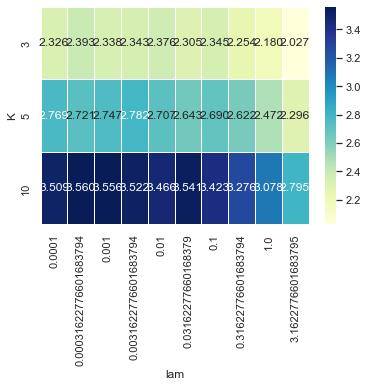

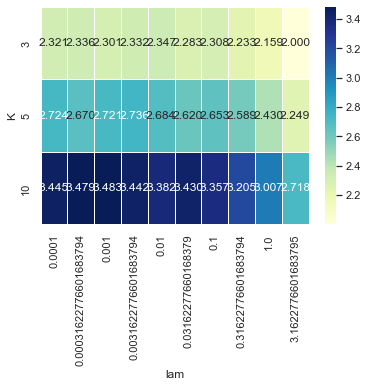

Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.157 RMSE: 2.256
Reg-LFM: ite: 1; diff: 0.060 RMSE: 2.196
Reg-LFM: ite: 2; diff: 0.043 RMSE: 2.153
Reg-LFM: ite: 3; diff: 0.034 RMSE: 2.120
Reg-LFM: ite: 4; diff: 0.028 RMSE: 2.092
Reg-LFM: ite: 5; diff: 0.024 RMSE: 2.068
Reg-LFM: ite: 6; diff: 0.021 RMSE: 2.047
Reg-LFM: ite: 7; diff: 0.019 RMSE: 2.028
Reg-LFM: ite: 8; diff: 0.017 RMSE: 2.012
Reg-LFM: ite: 9; diff: 0.015 RMSE: 1.997


In [16]:
## GLB_mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred_glb = glb_ave.predict(test_pairs)
train_rating_cm = train_ratings - glb_ave.predict(train_pairs)

# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pairs)

# fit GLB + user_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - user_ave.predict(train_pairs)
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pairs, train_rating_res)
pred = pred_user_mean + shiing.predict(test_pairs)
pred_rating = pred

In [20]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "GLB_user_LFM")

## user mean+item mean+LFM
* RMSE of training set = 
* RMSE of testing set = (in Kaggle)

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.055, valid_rmse: 2.064
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.008, valid_rmse: 2.030
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.079, valid_rmse: 2.120
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.242, valid_rmse: 2.245
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.104, valid_rmse: 2.100
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.088, valid_rmse: 2.032
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.031, valid_rmse: 2.015
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.984, valid_rmse: 2.043
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.301, valid_rmse: 2.328
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.127, valid_rmse: 2.169
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.029, valid_rmse: 2.033
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.102, valid_rmse: 2.093
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.024, valid_rmse: 2.067
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.060, valid_rmse: 2.061
3-Fold

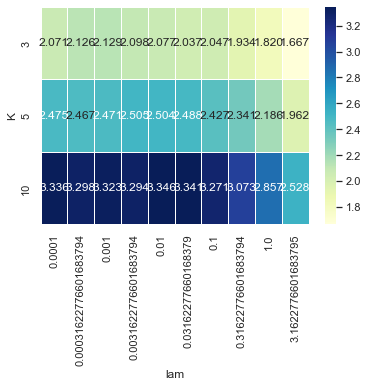

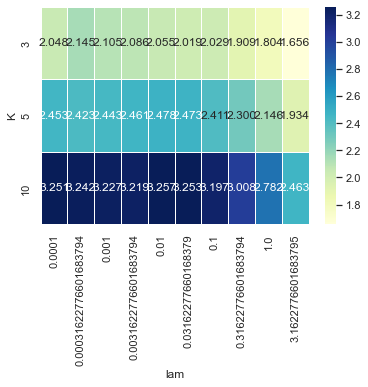

Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.135 RMSE: 1.925
Reg-LFM: ite: 1; diff: 0.079 RMSE: 1.846
Reg-LFM: ite: 2; diff: 0.055 RMSE: 1.791
Reg-LFM: ite: 3; diff: 0.042 RMSE: 1.749
Reg-LFM: ite: 4; diff: 0.034 RMSE: 1.716
Reg-LFM: ite: 5; diff: 0.028 RMSE: 1.687
Reg-LFM: ite: 6; diff: 0.024 RMSE: 1.663
Reg-LFM: ite: 7; diff: 0.021 RMSE: 1.642
Reg-LFM: ite: 8; diff: 0.019 RMSE: 1.623
Reg-LFM: ite: 9; diff: 0.017 RMSE: 1.606


In [18]:
## user_mean + item mean + LFM
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_ratings)
pred = user_ave.predict(test_pairs)

## item_mean
train_rating_cm = train_ratings - user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pairs)
pred = pred + item_ave.predict(test_pairs)


## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pairs, train_rating_res)
pred = pred + shiing.predict(test_pairs)
pred_rating = pred

In [22]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "user_item_LFM")

## GLB+user mean+item mean+LFM
* RMSE of training set = 

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.012, valid_rmse: 2.002
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.022, valid_rmse: 2.028
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.072, valid_rmse: 2.083
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 1.980, valid_rmse: 2.028
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.068, valid_rmse: 2.098
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.045, valid_rmse: 2.079
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.070, valid_rmse: 2.095
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.036, valid_rmse: 2.062
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.104, valid_rmse: 2.104
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.014, valid_rmse: 2.032
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.108, valid_rmse: 2.112
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.028, valid_rmse: 2.067
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.095, valid_rmse: 2.118
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.048, valid_rmse: 2.063
3-Fold

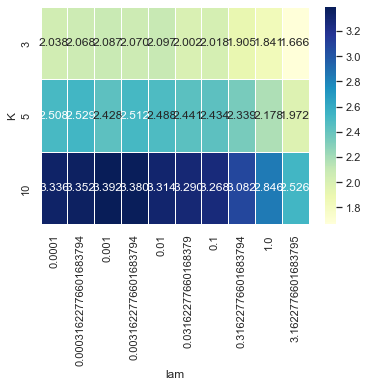

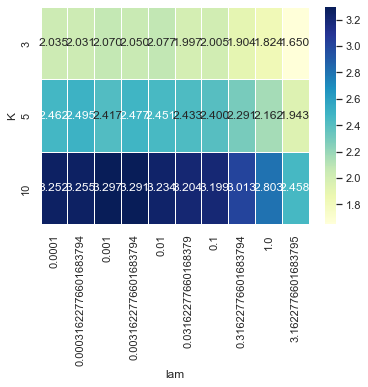

Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.189 RMSE: 1.930
Reg-LFM: ite: 1; diff: 0.080 RMSE: 1.851
Reg-LFM: ite: 2; diff: 0.053 RMSE: 1.797
Reg-LFM: ite: 3; diff: 0.040 RMSE: 1.757
Reg-LFM: ite: 4; diff: 0.033 RMSE: 1.724
Reg-LFM: ite: 5; diff: 0.028 RMSE: 1.696
Reg-LFM: ite: 6; diff: 0.024 RMSE: 1.672
Reg-LFM: ite: 7; diff: 0.021 RMSE: 1.651
Reg-LFM: ite: 8; diff: 0.019 RMSE: 1.631
Reg-LFM: ite: 9; diff: 0.017 RMSE: 1.614


In [24]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred = glb_ave.predict(test_pairs)

# user_mean
train_rating_res = train_ratings - glb_ave.predict(train_pairs)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pairs)

# item_mean
train_rating_res -=  user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pairs)
train_rating_res -= item_ave.predict(train_pairs)

# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pairs, train_rating_res)
pred = pred + shiing.predict(test_pairs)
pred_rating = pred

In [25]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "GLB_user_item_LFM")

# Method 2: ``Regression``: rating ~ user_features + item_features
## Step 1: generate `joint_feats` by emerge all user and item features

In [26]:
train_joint_feats=np.concatenate((user_pd_train.values, item_pd_train), axis=1)
test_joint_feats=np.concatenate((user_pd_test.values, item_pd_test.values), axis=1)

## Step 2: fit `regression`: rating ~ joint features  + `LFM`


In [27]:
reg = LinearRegression().fit(train_joint_feats, train_ratings)
reg_rating = reg.predict(test_joint_feats)
train_rating_res = train_ratings - reg.predict(train_joint_feats)

## Step 3: fit ``LFM`` after the regression

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.648, valid_rmse: 2.652
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.604, valid_rmse: 2.642
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.619, valid_rmse: 2.698
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.609, valid_rmse: 2.604
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.659, valid_rmse: 2.700
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.575, valid_rmse: 2.607
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.599, valid_rmse: 2.630
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.663, valid_rmse: 2.703
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.650, valid_rmse: 2.659
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.569, valid_rmse: 2.589
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.603, valid_rmse: 2.619
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.598, valid_rmse: 2.580
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.620, valid_rmse: 2.626
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.623, valid_rmse: 2.630
3-Fold

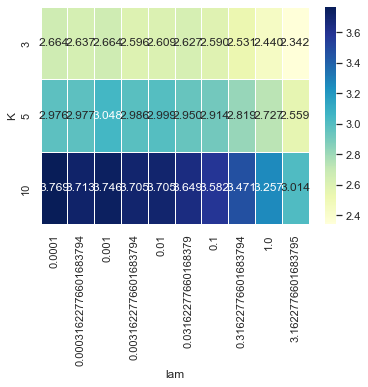

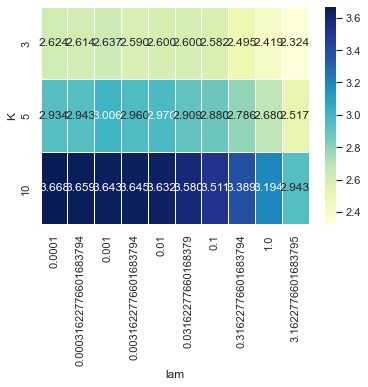

K             3.000000
lam           3.162278
train_rmse    2.324366
valid_rmse    2.342302
Name: 9, dtype: float64
Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.112 RMSE: 2.485
Reg-LFM: ite: 1; diff: 0.049 RMSE: 2.436
Reg-LFM: ite: 2; diff: 0.034 RMSE: 2.402
Reg-LFM: ite: 3; diff: 0.027 RMSE: 2.376
Reg-LFM: ite: 4; diff: 0.022 RMSE: 2.354
Reg-LFM: ite: 5; diff: 0.018 RMSE: 2.335
Reg-LFM: ite: 6; diff: 0.016 RMSE: 2.319
Reg-LFM: ite: 7; diff: 0.014 RMSE: 2.305
Reg-LFM: ite: 8; diff: 0.013 RMSE: 2.292
Reg-LFM: ite: 9; diff: 0.012 RMSE: 2.281


In [28]:
[3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pairs, train_rating_res)
pred_rating = reg_rating + shiing_best.predict(test_pairs)

In [30]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "reg_LFM")

# Method 3: ``RandomForest Regressor``: rating ~ user_features + item_features + `LFM`
## Step 1: fit `regression`: rating ~ joint features

In [31]:
regressor = RandomForestRegressor(n_estimators = 500, random_state = 3009)
regressor.fit(train_joint_feats, train_ratings)
pred_reg=regressor.predict(test_joint_feats)
train_rating_res = train_ratings - reg.predict(train_joint_feats)

## Step 2: fit ``LFM`` after the RandomForest Regressor

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.564, valid_rmse: 2.579
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.566, valid_rmse: 2.588
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.587, valid_rmse: 2.644
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.539, valid_rmse: 2.581
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.607, valid_rmse: 2.595
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.600, valid_rmse: 2.623
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.540, valid_rmse: 2.558
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.653, valid_rmse: 2.656
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.641, valid_rmse: 2.679
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.605, valid_rmse: 2.634
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.566, valid_rmse: 2.602
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.623, valid_rmse: 2.644
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.593, valid_rmse: 2.598
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.616, valid_rmse: 2.628
3-Fold

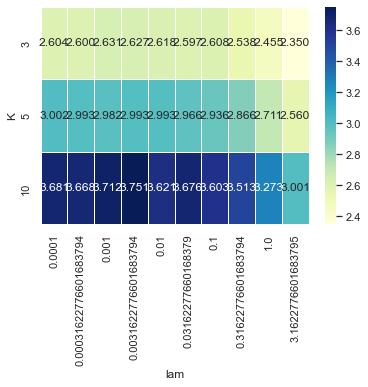

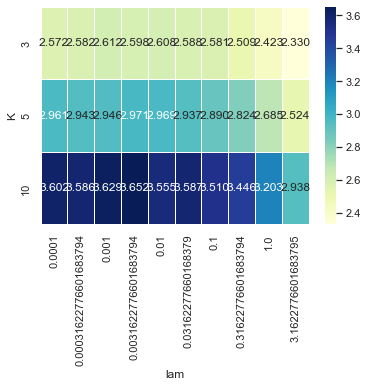

K             3.000000
lam           3.162278
train_rmse    2.330152
valid_rmse    2.349927
Name: 9, dtype: float64
Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.244 RMSE: 2.510
Reg-LFM: ite: 1; diff: 0.063 RMSE: 2.447
Reg-LFM: ite: 2; diff: 0.040 RMSE: 2.406
Reg-LFM: ite: 3; diff: 0.030 RMSE: 2.376
Reg-LFM: ite: 4; diff: 0.024 RMSE: 2.352
Reg-LFM: ite: 5; diff: 0.020 RMSE: 2.332
Reg-LFM: ite: 6; diff: 0.017 RMSE: 2.315
Reg-LFM: ite: 7; diff: 0.015 RMSE: 2.300
Reg-LFM: ite: 8; diff: 0.013 RMSE: 2.286
Reg-LFM: ite: 9; diff: 0.012 RMSE: 2.274


In [32]:
[3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pairs, train_rating_res)
pred_rating = reg_rating + shiing_best.predict(test_pairs)

In [35]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "rf_reg_LFM")

# Method 4: ``RandomForest Regressor``

In [36]:
# fit the regressor using RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 3009)
regressor.fit(train_joint_feats, train_ratings)
pred_rating=regressor.predict(test_joint_feats)

In [37]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "rf_reg")

# Method 5: ``GLB + user mean + item mean with sLFM`` without additional information
**WARNING: This method requires 2-3 hours computation time on normal computer**, these code is not deployed, but only showing in notebook.

In [38]:
pd.DataFrame(temp_train_user)['UserId']= train_pairs[:,0]
pd.DataFrame(temp_train_item)['ItemId']= train_pairs[:,1]

user_info = pd.DataFrame({'UserId': list(range(n_user))})
user_info = user_info.set_index('UserId')
user_info['V1'] = temp_train_user.groupby('UserId')['V1'].mean()
user_info['V2'] = temp_train_user.groupby('UserId')['V2'].mean()
user_info['V3'] = temp_train_user.groupby('UserId')['V3'].mean()
user_info['V4'] = temp_train_user.groupby('UserId')['V4'].mean()

## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)

item_info = pd.DataFrame({'ItemId': list(range(n_item))})
item_info = item_info.set_index('ItemId')
item_info['V1'] = temp_train_item.groupby('ItemId')['V1'].mean()
item_info['V2'] = temp_train_item.groupby('ItemId')['V2'].mean()
item_info['V3'] = temp_train_item.groupby('ItemId')['V3'].mean()

## fill NAN as the column mean
item_info = item_info.fillna(item_info.mean())
item_scaler = StandardScaler()
item_info = item_scaler.fit_transform(item_info)

In [40]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred = glb_ave.predict(test_pairs)

# user_mean
train_rating_res = train_ratings - glb_ave.predict(train_pairs)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pairs)

# item_mean
train_rating_res -=  user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pairs)

train_rating['res_rating'] = train_rating_res

## Cosine similarity

In [41]:
user_sim = cosine_similarity(user_info)
item_sim = cosine_similarity(item_info)

In [42]:
top = 5
index_item = [np.where(train_pairs[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pairs[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	obs_item_tmp = train_pairs[valid_user_ind,1]
	for i in range(n_item):
		top_item_tmp = item_sim[i].argsort()[-top:][::-1]
		valid_item_tmp = np.intersect1d(top_item_tmp, obs_item_tmp)
		if len(valid_item_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_item_tmp:
			valid_item_ind.extend(index_item[i_tmp])
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0
UserId: 1
UserId: 2


KeyboardInterrupt: 

In [ ]:
aug_pair, aug_rating_res = np.vstack((train_pairs, fake_pair)), np.hstack((train_rating_res, fake_rating))

Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(aug_pair, aug_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']

sSVD=LFM(n_user, n_item, K=best_K, lam=best_lam)
sSVD.fit(aug_pair, aug_rating_res)
pred = pred + sSVD.predict(test_pairs)
pred_rating = pred

In [ ]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "GLB_user_item_sLFM")

# Generate some additional side information for users and items
- Number of ratings
- Averaged ratings
- quantiles of the ratings

## Pre-processing the dataset
- combine with the given feature
- standardized as mean 0, std 1

In [43]:
pd.DataFrame(temp_train_user)['UserId']= train_pairs[:,0]
pd.DataFrame(temp_train_item)['ItemId']= train_pairs[:,1]

user_info = pd.DataFrame({'UserId': list(range(n_user))})
user_info = user_info.set_index('UserId')
user_info['mean'] = train_rating.groupby('UserId')['res_rating'].mean()
user_info['q1'] = train_rating.groupby('UserId')['res_rating'].quantile(.1)
user_info['q3'] = train_rating.groupby('UserId')['res_rating'].quantile(.3)
user_info['q5'] = train_rating.groupby('UserId')['res_rating'].quantile(.5)
user_info['q7'] = train_rating.groupby('UserId')['res_rating'].quantile(.7)
user_info['q9'] = train_rating.groupby('UserId')['res_rating'].quantile(.9)
user_info['V1'] = temp_train_user.groupby('UserId')['V1'].mean()
user_info['V2'] = temp_train_user.groupby('UserId')['V2'].mean()
user_info['V3'] = temp_train_user.groupby('UserId')['V3'].mean()
user_info['V4'] = temp_train_user.groupby('UserId')['V4'].mean()
user_info['Frequency'] = temp_train_user.groupby('UserId').size()
## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)


item_info = pd.DataFrame({'ItemId': list(range(n_item))})
item_info = item_info.set_index('ItemId')
item_info['mean'] = train_rating.groupby('ItemId')['res_rating'].mean()
item_info['q1'] = train_rating.groupby('ItemId')['res_rating'].quantile(.1)
item_info['q3'] = train_rating.groupby('ItemId')['res_rating'].quantile(.3)
item_info['q5'] = train_rating.groupby('ItemId')['res_rating'].quantile(.5)
item_info['q7'] = train_rating.groupby('ItemId')['res_rating'].quantile(.7)
item_info['q9'] = train_rating.groupby('ItemId')['res_rating'].quantile(.9)
item_info['V1'] = temp_train_item.groupby('ItemId')['V1'].mean()
item_info['V2'] = temp_train_item.groupby('ItemId')['V2'].mean()
item_info['V3'] = temp_train_item.groupby('ItemId')['V3'].mean()
item_info['Frequency'] = temp_train_item.groupby('ItemId').size()
## fill NAN as the column mean
item_info = item_info.fillna(item_info.mean())
item_scaler = StandardScaler()
item_info = item_scaler.fit_transform(item_info)

# Method 6: ``GLB + user mean + item with SLFM`` with additional side information
**WARNING: This method requires 2-3 hours computation time on normal computer**, these code is not deployed, but only showing in notebook.

In [45]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred = glb_ave.predict(test_pairs)

# user_mean
train_rating_res = train_ratings - glb_ave.predict(train_pairs)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pairs)

# item_mean
train_rating_res -=  user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pairs)

train_rating['res_rating'] = train_rating_res

## Cosine similarity

In [157]:
user_sim = cosine_similarity(user_info)
item_sim = cosine_similarity(item_info)

In [158]:
top = 5
index_item = [np.where(train_pairs[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pairs[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	obs_item_tmp = train_pairs[valid_user_ind,1]
	for i in range(n_item):
		top_item_tmp = item_sim[i].argsort()[-top:][::-1]
		valid_item_tmp = np.intersect1d(top_item_tmp, obs_item_tmp)
		if len(valid_item_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_item_tmp:
			valid_item_ind.extend(index_item[i_tmp])
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0


KeyboardInterrupt: 

In [ ]:
aug_pair, aug_rating_res = np.vstack((train_pairs, fake_pair)), np.hstack((train_rating_res, fake_rating))

Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(aug_pair, aug_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']

sSVD=LFM(n_user, n_item, K=best_K, lam=best_lam)
sSVD.fit(aug_pair, aug_rating_res)
pred = pred + sSVD.predict(test_pairs)
pred_rating = pred

In [ ]:
sub['rating'] = pred_rating
sub.to_csv('predict/GLB_user_item_sLFM_add.csv', index=False)

# Method 7: ``NCF`` Model based on side information

In [14]:
# Import tensorflow library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Step 1: Formulate neural network based on continuous and categorical features
- embedding for categorical features
- concatenate continuous features and all embedding vectors

In [15]:
class SideNCF(keras.Model):
    def __init__(self, num_users, num_movies, num_genre, embedding_size, **kwargs):
        super(SideNCF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.genre_embedding = layers.Embedding(
            num_genre,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.concatenate = layers.Concatenate()
        self.dense1 = layers.Dense(100, name='fc-1', activation='relu')
        self.dense2 = layers.Dense(50, name='fc-2', activation='relu')
        self.dense3 = layers.Dense(1, name='fc-3', activation='relu')

    def call(self, inputs):
        cont_feats = inputs[0]
        cate_feats = inputs[1]
        user_vector = self.user_embedding(cate_feats[:,0])
        movie_vector = self.movie_embedding(cate_feats[:,1])
        genre_vector = self.genre_embedding(cate_feats[:,2])
        concatted_vec = self.concatenate([cont_feats, user_vector, movie_vector, genre_vector])
        fc_1 = self.dense1(concatted_vec)
        fc_2 = self.dense2(fc_1)
        fc_3 = self.dense3(fc_2)
        return fc_3

In [ ]:
## NOT RUN:
if False:
    num_genre = movies_pd['pGenre'].max() + 1
    model = SideNCF(num_users=n_user, num_movies=n_item, num_genre=num_genre, embedding_size=50)

    metrics = [
        keras.metrics.MeanAbsoluteError(name='mae'),
        keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3), 
        loss=tf.keras.losses.MeanSquaredError(), 
        metrics=metrics
    )

# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [16]:
# tran_pair, train_rating
train_pairs = train_rating[['UserId', 'ItemId']].values
train_ratings = train_rating['rating'].values
# test_pair
test_pairs = test_pair[['UserId', 'ItemId']].values
n_user, n_item = max(train_pairs[:,0].max(), test_pairs[:,0].max())+1, max(train_pairs[:,1].max(), test_pairs[:,1].max())+1

# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_ratings)
pred_user_mean = user_ave.predict(test_pairs)

## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_ratings)
pred_item_mean = item_ave.predict(test_pairs)

user_rating=pd.concat([test_pair,pd.DataFrame({'rating':pred_user_mean})],axis=1)
item_rating=pd.concat([test_pair,pd.DataFrame({'rating':pred_item_mean})],axis=1)

In [17]:
## generate cont feats for users
user_pd_test = pd.merge(left=user_rating.groupby('UserId')['rating'].mean(), 
                        right=user_rating.groupby('UserId')['rating'].count(), on='UserId', )
user_pd_test = pd.merge(left=user_pd_test, 
                        right=user_rating.groupby('UserId')['rating'].quantile([0.1]), on='UserId', )
user_pd_test = pd.merge(left=user_pd_test, 
                        right=user_rating.groupby('UserId')['rating'].quantile([0.9]), on='UserId', )

user_pd_test.columns = ['rating_mean', 'rating_count','quantile_0.1','quantile_0.9']
user_pd_test = user_pd_test.reset_index()

user_pd_test = pd.merge(left=user_pd_test, right=user_feat, on='UserId')

## generate cont feats for items
item_rating_pd_test = pd.merge(left=item_rating.groupby('ItemId')['rating'].mean(), 
                            right=item_rating.groupby('ItemId')['rating'].count(), on='ItemId')
item_rating_pd_test = pd.merge(left=item_rating_pd_test, 
                        right=item_rating.groupby('ItemId')['rating'].quantile([0.1]), on='ItemId', )
item_rating_pd_test = pd.merge(left=item_rating_pd_test, 
                        right=item_rating.groupby('ItemId')['rating'].quantile([0.9]), on='ItemId', )
item_rating_pd_test.columns = ['rating_mean', 'rating_count','quantile_0.1','quantile_0.9']
item_rating_pd_test = item_rating_pd_test.reset_index()

item_pd_test = pd.merge(left=item_rating_pd_test, right=item_feat, on='ItemId')
print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')

print(user_pd_test.sample(10))
print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')

print(item_pd_test.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
      UserId  rating_mean  rating_count  quantile_0.1  quantile_0.9        V1  \
1172    8521     2.388889             3      2.388889      2.388889  3.730347   
1185    8604     4.000000             2      4.000000      4.000000  3.423729   
400     2833     3.750000             1      3.750000      3.750000  3.496638   
2781   19749     0.000000             1      0.000000      0.000000  3.423729   
411     2934     1.643851             1      1.643851      1.643851  3.423729   
76       566     1.643851             1      1.643851      1.643851  3.423729   
3482   24633     0.583333             6      0.583333      0.583333  3.396787   
1502   10792     1.643851             2      1.643851      1.643851  3.693586   
1994   14430     1.643851             1      1.643851      1.643851  3.423729   
916     6775     1.643

In [18]:
## pre-processing for users
user_cont = ['rating_mean', 'rating_count', 'quantile_0.1','quantile_0.9', 'V1','V2','V3','V4']
user_pd_test[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd_test[user_cont])

## pre-processing for items
item_cont = ['rating_mean', 'rating_count', 'quantile_0.1','quantile_0.9', 'V1','V2','V3']
item_pd_test[item_cont] = preprocessing.StandardScaler().fit_transform(item_pd_test[item_cont])


print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd_test.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd_test.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
      UserId  rating_mean  rating_count  quantile_0.1  quantile_0.9        V1  \
1184    8599    -1.199031      0.445585     -1.199031     -1.199031  1.099786   
2218   16087     0.971913     -0.145845      0.971913      0.971913 -0.033176   
2959   20957     2.280167     -0.145845      2.280167      2.280167  1.300159   
3819   26919     1.407998     -0.145845      1.407998      1.407998  0.447614   
2240   16239     0.535828     -0.041475      0.535828      0.535828  0.216765   
759     5556    -0.210879     -0.111055     -0.210879     -0.210879 -0.033176   
2241   16249    -0.210879      0.167265     -0.210879     -0.210879 -6.109132   
1424   10260    -0.210879     -0.145845     -0.210879     -0.210879 -0.033176   
3343   23725    -0.210879     -0.145845     -0.210879     -0.210879 -0.157632   
3731   26348     1.368

In [19]:
# joint_feats of test
user_pd_test=user_pd_test.values
item_pd_test=item_pd_test.values

In [20]:
temp_user=np.zeros((len(test_pairs), len(user_pd_test[0,:])-1))
for i in range(len(test_pairs)):
    index=np.where(test_pairs[i,0]==user_pd_test[:,0])[0]
    temp_user[i,:]=user_pd_test[index,1:len(user_pd_test[0,:])]
    
temp_item=np.zeros((len(test_pairs), len(item_pd_test[0,:])-1))
for i in range(len(test_pairs)):
    index=np.where(test_pairs[i,1]==item_pd_test[:,0])[0]
    temp_item[i,:]=item_pd_test[index,1:len(item_pd_test[0,:])]

test_joint_feats=np.concatenate((temp_user, temp_item), axis=1)

In [51]:
temp_user=np.zeros((len(train_pairs), len(user_pd[0,:])-1))
for i in range(len(train_pairs)):
    index=np.where(train_pairs[i,0]==user_pd[:,0])[0]
    temp_user[i,:]=user_pd[index,1:len(user_pd[0,:])]
    
temp_item=np.zeros((len(train_pairs), len(item_pd[0,:])-1))
for i in range(len(train_pairs)):
    index=np.where(train_pairs[i,1]==item_pd[:,0])[0]
    temp_item[i,:]=item_pd[index,1:len(item_pd[0,:])]

train_joint_feats=np.concatenate((temp_user, temp_item), axis=1)

In [42]:
## generate cont feats for users
user_pd= pd.concat([train_rating, GLB_mean_pred, user_mean_pred,item_mean_pred,cor_user_pred,cor_item_pred], axis=1)


user_pd = pd.merge(left=GLB_mean_pred.groupby('UserId')['rating'], 
                        right=train_rating.groupby('UserId')['rating'].count(), on='UserId', )
user_pd = pd.merge(left=user_pd, 
                        right=train_rating.groupby('UserId')['rating'].quantile([0.1]), on='UserId', )
user_pd = pd.merge(left=user_pd, 
                        right=train_rating.groupby('UserId')['rating'].quantile([0.9]), on='UserId', )

user_pd.columns = ['rating_mean', 'rating_count','quantile_0.1','quantile_0.9']
user_pd = user_pd.reset_index()

user_pd = pd.merge(left=user_pd, right=user_feat, on='UserId')

## generate cont feats for items
item_rating_pd = pd.merge(left=train_rating.groupby('ItemId')['rating'].mean(), 
                            right=train_rating.groupby('ItemId')['rating'].count(), on='ItemId')
item_rating_pd = pd.merge(left=item_rating_pd, 
                        right=train_rating.groupby('ItemId')['rating'].quantile([0.1]), on='ItemId', )
item_rating_pd = pd.merge(left=item_rating_pd, 
                        right=train_rating.groupby('ItemId')['rating'].quantile([0.9]), on='ItemId', )
item_rating_pd.columns = ['rating_mean', 'rating_count','quantile_0.1','quantile_0.9']
item_rating_pd = item_rating_pd.reset_index()

item_pd = pd.merge(left=item_rating_pd, right=item_feat, on='ItemId')
print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')

print(user_pd.sample(10))
print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')

print(item_pd.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
      UserId  rating_mean  rating_count  quantile_0.1  quantile_0.9        V1  \
2530   11780     4.000000             1           4.0          4.00  3.919329   
973     4533     5.000000             1           5.0          5.00  2.934012   
680     3199     3.500000             1           3.5          3.50  3.423729   
219      996     1.392857            14           0.0          3.85  3.423729   
2994   14043     0.000000             1           0.0          0.00  2.835416   
2365   10980     1.500000             1           1.5          1.50  4.000485   
356     1657     0.000000             1           0.0          0.00  3.303097   
3041   14302     0.000000             1           0.0          0.00  3.549563   
152      696     4.000000             1           4.0          4.00  3.953528   
2639   12348     4.500